In [1]:
import numpy as np
from numpy import unravel_index
import matplotlib.pyplot as plt
import random
from scipy.optimize import least_squares
import sys
from vector_class import TripleVector
from scipy.optimize import curve_fit


# Parameters

In [71]:
A_min = 1e3 # Bq
A_max = 2e3 # Bq
Ab = 5e-5 # Bq
h = 10 # m
dt = 100 # the pause on each point od the grid in s
x_max = 4; sigma_x = 0.1 # m
y_max = 4; sigma_y = 0.1 # m
grid = 8
n_bins = 20
K = 0.1 # is somewhere in the interval [0, 1]
F = 0.140 # factor for inhilation of Pu-239 in mSV/Bq

radiation = {"A_min": A_min, "A_max": A_max, "Ab": Ab, "dt": dt, "dose_factor": F}
detector = {"h": h, "x_max": x_max, "y_max": y_max, "grid": grid, "detector_constant": K} # the detector constant tells us the quality of the 
                                                                                          # detector


## Flyover

In [78]:
 # it equals to the activity multiplied by the time of measuring - number of events measured at the location
def N_func(source, x, y, h, dt):
    u, v, A0 = source[0], source[1], source[2] # u, v are the coordinates of the source and A0 is its activity
    return (A0*dt) / ((x - u)**2 + (y - v)**2 + h**2)

def point_source(x_max, y_max, A_min, A_max, x_min=0, y_min=0):
    if (x_min == 0) and (y_min == 0):    
        return [random.uniform(-x_max, x_max), random.uniform(-y_max, y_max), random.uniform(A_min, A_max)]
    else:
        return [random.uniform(x_min, x_max), random.uniform(y_min, y_max), random.uniform(A_min, A_max)]

# Noise is a list that contanins the standard deviations of x/y coordinates as a result of the error of the detector
def flyover(radiation, detector, source = [], noise = []):
    A_min, A_max, Ab, dt = radiation["A_min"], radiation["A_max"], radiation["Ab"], radiation["dt"]
    h, x_max, y_max, grid, K = detector["h"], detector["x_max"], detector["y_max"], detector["grid"], detector["detector_constant"]
    N_grid = grid
    square_x, square_y = (2*x_max)/N_grid, (2*y_max)/N_grid

    grid_x, grid_y = np.zeros((N_grid, N_grid)), np.zeros((N_grid, N_grid))
    grid_x_noise, grid_y_noise = np.zeros((N_grid, N_grid)), np.zeros((N_grid, N_grid))
    xs = np.linspace(-x_max + square_x/2, x_max - square_x/2, int(N_grid))
    
    # If the source is not specified, then it is randomly generated 
    if len(source) == 0: 
        source = point_source(x_max, y_max, A_min, A_max)
    Ns = np.zeros((int(N_grid), int(N_grid)))
    
    n, m = N_grid - 1, 0
    y = -y_max + square_y/2
    i = 1
    for x in xs:
        while abs(y) <= y_max:
            N = N_func(source, x, y, h, dt)
            
            # Add noise to the location data because of the GPS uncertianty
            if len(noise) != 0:
                sigma_x = noise[0]; sigma_y = noise[1]
                grid_x_noise[n, m] = x + np.random.normal(0, sigma_x)
                grid_y_noise[n, m] = y + np.random.normal(0, sigma_y)

            # Don't count the signal which is weaker than the background
            if Ab* dt > N:
                Ns[n, m] = 0
            else:
                Ns[n, m] = N*(1 - K) - Ab*dt
            
            grid_x[n, m] = x; grid_y[n, m] = y
            y += (square_y)*i
            n -= 1*i
        n += 1*i; i = i * (-1); y += (square_y)*i; m += 1
    i_max, j_max = unravel_index(Ns.argmax(), Ns.shape)
    x_c, y_c = grid_x[i_max, j_max], grid_y[i_max, j_max]
    maxI_range = {"xrange": (x_c - square_x/2, x_c + square_x/2), "yrange": (y_c - square_x/2, y_c + square_x/2)}

    return {"N_array": Ns, "source": source, "grid_x": grid_x, "grid_y": grid_y, "grid_x_noise": grid_x_noise, "grid_y_noise": grid_y_noise, "hotspot": maxI_range, "square_x": square_x, "square_y": square_y}

measurement = flyover(radiation, detector)

# hotspot = measurement["hotspot"]
# x_0, x_1 = hotspot["xrange"]; y_0, y_1 = hotspot["yrange"]



## Location from measurement - Levenberg-Marquardt method

### Scipy least square

In [4]:
# Using the Levenberg-Marquardt method with scipy least squares
def locationLM(measurement, radiation, detector):
    A_min, A_max, dt = radiation["A_min"], radiation["A_max"], radiation["dt"]
    h = detector["h"]
    hotspot = measurement["hotspot"]
    x_0, x_1 = hotspot["xrange"]; y_0, y_1 = hotspot["yrange"]
    def N(source, x, y):
        return N_func(source, x, y, h, dt)

    grid_x, grid_y = measurement["grid_x"], measurement["grid_y"]
    Ns = measurement["N_array"]

    def fun(source):
        return (N(source, grid_x, grid_y) - Ns).flatten()

    source0 = point_source(x_0, y_0, A_min, A_max, x_1, y_1)
    res = least_squares(fun, source0, method="lm")

    return res["x"]

measurement = flyover(radiation, detector)
sourceLM = locationLM(measurement, radiation, detector)



### Scipy curve fit

In [5]:
# Also location with LM method, only now using the curve_fit scipy.optimize function 
def locationCF(measurement, radiation, detector, noise = []):
    Ns, grid_x, grid_y, hotspot = measurement['N_array'], measurement['grid_x'], measurement['grid_y'], measurement["hotspot"] # in example Z, here Is
    grid_x_noise = measurement['grid_x_noise']; grid_y_noise = measurement['grid_y_noise']
    A_min, A_max, dt = radiation["A_min"], radiation["A_max"], radiation["dt"]
    h = detector["h"]

    x_0, x_1 = hotspot["xrange"]; y_0, y_1 = hotspot["yrange"]

    if len(noise) == 0:
        XY = np.vstack((grid_x.ravel(), grid_y.ravel()))
    else:
        XY = np.vstack((grid_x_noise.ravel(), grid_y_noise.ravel()))
    source0 = point_source(x_0, y_0, A_min, A_max, x_1, y_1)
    
    def N(x, y, u, v, A0): # it equals to the activity multiplied by the time of measuring u, v are the coordinates of the source and A0 
        return (A0*dt) / ((x - u)**2 + (y - v)**2 + h**2) # is its activity

    def _N(M, *args): # M is a table of shape (N, 2), where each row is a new point of measurement, N is the number of measuremnts
        x, y = M
        arr = np.zeros(x.shape)
        for i in range(len(args)//3):
            arr += N(x, y, *args[i*3:i*3+3])
        return arr

    popt, pcov = curve_fit(_N, XY, Ns.ravel(), source0, method="lm")
    perr = np.sqrt(np.diag(pcov))
    

    MyDict = {"XY": XY, "Ns": Ns, "source0": source0}

    return popt, perr, MyDict


sourceCF = locationCF(measurement, radiation, detector) 


### Standard deviation

In [6]:
def locationCFerror(measurement, radiation, detector):
    h = detector["h"]; dt = radiation["dt"]
    dx = detector["dx"]; dy = detector["dy"]
    
    def intensity(x, y, u, v, A0): # it equals to the activity multiplied by the time of measuring u, v are the coordinates of the source and A0 
        return (A0*dt) / ((x - u)**2 + (y - v)**2 + h**2) # is its activity

    def _intensity(M, *args): # M is a table of shape (N, 2), where each row is a new point of measurement, N is the number of measuremnts
        x, y = M
        arr = np.zeros(x.shape)
        for i in range(len(args)//3):
            arr += intensity(x, y, *args[i*3:i*3+3])
        return arr
    
    popt0, perr0 = locationCF(measurement, radiation, detector)[0], locationCF(measurement, radiation, detector)[1]
    u = popt0[0]; v = popt0[1]; A0 = popt0[2]
    du = perr0[0]; dv = perr0[1]; dA0 = perr0[2]

    MyDict = locationCF(measurement, radiation, detector)[2]
    XY = MyDict["XY"]; Is = MyDict["Is"]; source0 = MyDict["source0"]

    def stDev_I(x, y, u, v, A0):
        C = ((A0 * dt) / ((x-u)**2 + (x-v)**2 + h**2))
        return C * np.sqrt(4*(dx**2 + du**2)*(x - u)**2 + 4*(dy**2 + dv**2)*(y - v)**2 + (((x - u)**2 + (y - v)**2 + h**2)**2 / A0**2)*dA0**2)
    

    dIs = np.array([stDev_I(x, y, u, v, A0) for x in XY[0] for y in XY[0]])
    popt, pcov = curve_fit(_intensity, XY, Is.ravel(), sigma = dIs.ravel(), absolute_sigma=True)

    return popt, pcov

# print(locationCFerror(measurement, radiation, detector))


### TUTORIALS

#### Scipy least square minimization example  

In [ ]:
def h(theta, x, y, h):
    return theta[2] * (x - theta[0])**2 + theta[3] * (y - theta[1])**2 - h

xs = np.linspace(-1, 1, 20)
ys = np.linspace(-1, 1, 20)
dt = 10
gridx, gridy = np.meshgrid(xs, ys)
x0 = 0.1; y0 = -0.15; a = 1; b = 2; noise = 0.1
hs = h([x0, y0, a, b], gridx, gridy, 10) * dt
# hs += noise * np.random.default_rng().random(hs.shape)

print(hs)

def fun(theta):
    return (h(theta, gridx, gridy, 10) * dt - hs).flatten()

theta0 = [0, 0, 1, 2]
res3 = least_squares(fun, theta0)

# print(hs)


#### Scipy curve fit for 2D data example

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# The two-dimensional domain of the fit.
xmin, xmax, nx = -5, 4, 75
ymin, ymax, ny = -3, 7, 150
x, y = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y)

# Our function to fit is going to be a sum of two-dimensional Gaussians
def gaussian(x, y, x0, y0, xalpha, yalpha, A):
    return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2)

# A list of the Gaussian parameters: x0, y0, xalpha, yalpha, A
gprms = [(0, 2, 2.5, 5.4, 1.5),
         (-1, 4, 6, 2.5, 1.8),
         (-3, -0.5, 1, 2, 4),
         (3, 0.5, 2, 1, 5)
        ]

# Standard deviation of normally-distributed noise to add in generating
# our test function to fit.
noise_sigma = 0.1

# The function to be fit is Z.
Z = np.zeros(X.shape)
for p in gprms:
    Z += gaussian(X, Y, *p)
Z += noise_sigma * np.random.randn(*Z.shape) # In our example this are the measured intesities Is

# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, cmap='plasma')
ax.set_zlim(0,np.max(Z)+2)
plt.show()

# This is the callable that is passed to curve_fit. M is a (2,N) array
# where N is the total number of data points in Z, which will be ravelled
# to one dimension.
def _gaussian(M, *args):
    x, y = M
    arr = np.zeros(x.shape)
    for i in range(len(args)//5):
       arr += gaussian(x, y, *args[i*5:i*5+5])
    return arr

# Initial guesses to the fit parameters.
guess_prms = [(0, 0, 1, 1, 2),
              (-1.5, 5, 5, 1, 3),
              (-4, -1, 1.5, 1.5, 6),
              (4, 1, 1.5, 1.5, 6.5)
             ]
# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

# We need to ravel the meshgrids of X, Y points to a pair of 1-D arrays.
xdata = np.vstack((X.ravel(), Y.ravel()))
# Do the fit, using our custom _gaussian function which understands our
# flattened (ravelled) ordering of the data points.
popt, pcov = curve_fit(_gaussian, xdata, Z.ravel(), p0)
fit = np.zeros(Z.shape)
for i in range(len(popt)//5):
    fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((Z - fit)**2))
print('RMS residual =', rms)

# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, fit, cmap='plasma')
cset = ax.contourf(X, Y, Z-fit, zdir='z', offset=-4, cmap='plasma')
ax.set_zlim(-4,np.max(fit))
plt.show()



## Combine

In [44]:
# combines the detector flyover and the location detection
def combination(radiation, detector, source=[], noise=[]):
    measurement = flyover(radiation, detector, source, noise)
    sourceLM = locationLM(measurement, radiation, detector)
    sourceCF, stDev = locationCF(measurement, radiation, detector, noise)[0], locationCF(measurement, radiation, detector, noise)[1]
    eff_dose = sourceCF[2] * radiation["dose_factor"]; deff_dose = stDev[2] * radiation["dose_factor"]
    return {'measurement': measurement, 'source_locationLM': sourceLM, 'source_locationCF': sourceCF, "sourceCF_stDev": stDev, "effective_dose": [eff_dose, deff_dose]}

data = combination(radiation, detector, [], [])


In [10]:
def radioactive_dose(C, Dt, data):
    A0 = data['source_locationCF'][2]
    Hd = C * A0 * Dt
    rel_Hd = 1/np.sqrt(Hd/C)
    return {"Hd": Hd, "rel_Hd": rel_Hd}

det1 = radioactive_dose(1e6, 100, data)
det2 = radioactive_dose(1e8, 100, data)

print(det1, "\n", det2)


{'Hd': 1.9413321279377133e+17, 'rel_Hd': 2.269603952119381e-06} 
 {'Hd': 1.9413321279377134e+19, 'rel_Hd': 2.269603952119381e-06}


## Visualization

1500000.0 1000000.0


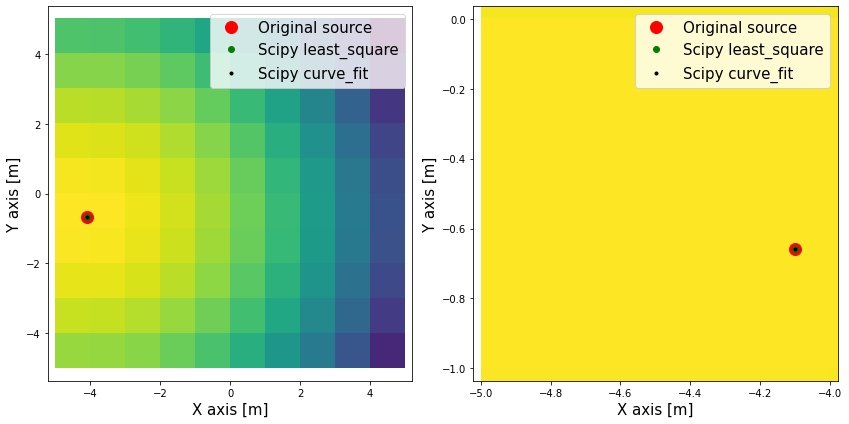

In [76]:
def visualize(measurement, x_max, y_max, points):
    X, Y = measurement["source"][0], measurement["source"][1]
    u1, v1 = points[0][0], points[0][1]
    u2, v2 = points[1][0], points[1][1]
    # print((u1, v1), (u2, v2))

    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))
    
    im = ax1.imshow(measurement["N_array"], extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    ax1.plot(X, Y, "o", color = 'r', ms=12, label = "Original source")
    ax1.plot(u1, v1, "o", color = 'g', ms=6, label = "Scipy least_square")
    ax1.plot(u2, v2, "o", color = 'k', ms=3, label = "Scipy curve_fit")

    ax1.axis("equal")
    ax1.set_xlabel("X axis [m]", fontsize = 15)
    ax1.set_ylabel("Y axis [m]", fontsize = 15)
   
    ax1.legend(fontsize = 15)

    hotspot = measurement["hotspot"]
    x_0, x_1 = hotspot["xrange"]; y_0, y_1 = hotspot["yrange"]

    ax2.imshow(measurement["N_array"], extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    ax2.plot(X, Y, "o", color = 'r', ms=12, label = "Original source")
    ax2.plot(u1, v1, "o", color = 'g', ms=6, label = "Scipy least_square")
    ax2.plot(u2, v2, "o", color = 'k', ms=3, label = "Scipy curve_fit")
    ax2.axis("equal")
    ax2.set_xlim(x_0, x_1)
    ax2.set_xlabel("X axis [m]", fontsize = 15)
    ax2.set_ylim(y_0, y_1)
    ax2.set_ylabel("Y axis [m]", fontsize = 15)

   
    ax2.legend(fontsize = 15)    

    plt.tight_layout()
    # plt.savefig("graphics/imporved.jpg")
    plt.show()
    # return points[1]
    # print(measurement["intensities_array"], '\n', measurement["grid_x"], '\n', measurement["grid_y"])

# 0.1, 0.1, 100
data = combination(radiation, detector, [], [])

print(A_max, A_min)

visualize(data["measurement"], detector["x_max"], detector["y_max"], [data["source_locationLM"], data["source_locationCF"]])


## Analysis

### Standard deviation

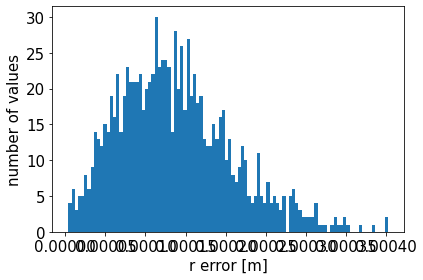

7.075455872098622e-05


In [12]:
def dist_points(point1, point2):
    return (point1 - point2).magnitude()

# run simulation n_sim times and keep track of the distance between the original source and estimated source. Plot a histogram for the values.
def stDev(radiation, detector, n_sim):
    R = []
    for i in range(n_sim):
        data = combination(radiation, detector)
        original = (data["measurement"])["source"]
        estimate = data["source_locationLM"]
        R.append(dist_points(TripleVector(original[0], original[1], 0), TripleVector(estimate[0], estimate[1], 0)))
 
    plt.hist(np.array(R), 100)
    plt.xlabel("r error [m]", fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.ylabel("number of values", fontsize = 15)
    plt.yticks(fontsize = 15)

    #plt.legend(fontsize = 15)
    #plt.grid()

    plt.tight_layout()
    # plt.savefig("graphics/dr_hist.jpg")
    plt.show()

    d_R = np.std(R)

    return d_R

n_sim = 1000
print(stDev(radiation, detector, n_sim))

### Scipy curve_fit sigma analysis

In [13]:
source1 = point_source(x_max, y_max, A_min, A_max)

In [ ]:
def sigmaAnalysis(radiation, detector, source1, sigmas):
    listX = []; listY = []; listA0 = []
    for sigma in sigmas:
        data = combination(radiation, detector, source1, sigma)
        perr = data["sourceCF_stDev"]
        listX.append(perr[0]); listY.append(perr[1]); listA0.append(perr[2])

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    
    ax1.plot(sigmas, listX, "o", color = "r", ms=7, label = "X coordinates")
    ax1.plot(sigmas, listY, "o", color = "b", ms=6, label = "Y coordinates")

    ax1.set_xlabel("Relative error of measurements of intnesity")
    ax1.set_ylabel("Absolute error [m]")

    ax1.legend(fontsize = 15)


    ax2.plot(sigmas, listA0, "o", color = "g", label = "Source activity")

    ax2.set_xlabel("Relative error of measurements of intnesity")
    ax2.set_ylabel("Absolute error [Bq]")

    ax2.legend(fontsize = 15)

sigmas = np.linspace(0, 0.1, 100)
sigmaAnalysis(radiation, detector, source1, sigmas)


# Code description

u = 3.5445492667763565 ± 1.1784010793120064e-05 m
v = 1.1175443188281315 ± 1.1622141958943364e-05 m
A0 = 1324.6587423688238 ± 8.762178493010199e-05 Bq


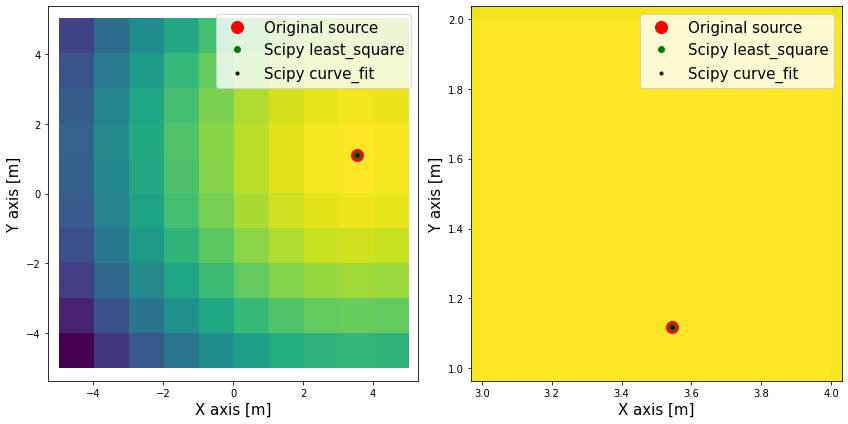

In [83]:
# DESCRIPTION OF THE CODE

# In comparisson to the code in simple_SPS.ipynb there are a few minor changes. The intensity function is defined diferently. It takes into
# consideration two points, the source of the radiation and the position of a measurement. Flyover() is very similar to the older version 
# it just uses the new intensity and also the activity of the source is randomly generated - it is one of the parameters which we are fitting.

# locationLM() is the major chenge. We use the scipy least square Levenberg-marquardt method to minimize the square residuals of the model 
# intensity and the measured intensity. Through the minimization we can output the paramaters which we are searching for - u, v and A0 (x/y 
# coordinates of the source and its intensity).

# visualize() shows us that this method is much more accurate then the previously used location searching method.

# PARAMETERS
A_min = 1e3; A_max = 1.5e3 # borders between which the activity of the source is randomly selected 
Ab = 5e-5 # background activity in Bq
h = 40 # hight at which the detector flies over in m
x_max = 5 # Size of the area of flyover in positive x direction in m (the whole grid extends also in the negative direction the same amount)
y_max = 5 # Size of the area of flyover in positive y direction in m (the whole grid extends also in the negative direction the same amount)
grid = 10 # Size of the grid in which the area of flyover is divided into smaller "tiles" where the detector stops and measures the number of 
         # radioactive decays. Grid is the number of these areas in x direction and y direction. It must be an INTEGER!
dt = 100 # the pause on each point od the grid in s
n_bins = 20 # number of bins in the histogram made by find_source()
noise = [0.5, 0.5] # list that contains the standard deviation of the x and y coordinates in in m
K = 0 # constant between 0 and 1 which contains the information on the quality of the detector, a better detector has a smaller constante 
        # then then an inferior detector
F = 0.140 # factor for inhilation of Pu-239 in mSV/Bq


# Combinig the parameters into a list so that the data is more compacted
radiation = {'A_min': A_min, 'A_max': A_max, 'Ab': Ab, 'dt': dt, 'dose_factor': F}
detector = {'h': h, 'x_max': x_max, 'y_max': y_max, 'grid': grid, 'detector_constant': K}

data = combination(radiation, detector, [], [])

# print(data["sourceCF_stDev"])

# Print out the fitted parameters with their absolute errors (standard deviation)
print("u =", data["source_locationCF"][0], r'±', data["sourceCF_stDev"][0], "m")
print("v =", data["source_locationCF"][1], r'±', data["sourceCF_stDev"][1], "m")
print("A0 =", data["source_locationCF"][2], r'±', data["sourceCF_stDev"][2], "Bq")

visualize(data["measurement"], detector["x_max"], detector["y_max"], [data["source_locationLM"], data["source_locationCF"]])


### Detector constant analysis

In [84]:
testSource = point_source(x_max, y_max, A_min, A_max)
testSource1 = [x_max, y_max, (A_max-A_min)/2]
testSource1

[5, 5, 250.0]

In [86]:
# Analysis for detectors without noise, detector0 is an ideal detector and detector1 is a superior real detector to the real detector2
detector0 = {'h': h, 'x_max': x_max, 'y_max': y_max, 'grid': grid, 'detector_constant': 0.}
detector1 = {'h': h, 'x_max': x_max, 'y_max': y_max, 'grid': grid, 'detector_constant': 0.1}
detector2 = {'h': h, 'x_max': x_max, 'y_max': y_max, 'grid': grid, 'detector_constant': 0.6}

# We generate the data measurement and analysis for the same source, same grid and everything, the only difference between the detectors is K
data0 = combination(radiation, detector0, testSource, [])
data1 = combination(radiation, detector1, testSource, [])
data2 = combination(radiation, detector2, testSource, [])

# Calculated acitvities of the source in Bq
A00, dA00 = data0["source_locationCF"][2], data0["sourceCF_stDev"][2]
A01, dA01 = data1["source_locationCF"][2], data1["sourceCF_stDev"][2]
A02, dA02 = data2["source_locationCF"][2], data2["sourceCF_stDev"][2]

# Calculated effective dosese in mSv
ED0, dED0 = data0["effective_dose"][0], data0["effective_dose"][1]
ED1, dED1 = data1["effective_dose"][0], data1["effective_dose"][1]
ED2, dED2 = data2["effective_dose"][0], data2["effective_dose"][1]

# The [u, v] data is virtually the same for all detectors(with higher errors for worse detectors), but A0 is not the same although they are all 
# measuring the same source!
# print("DETECTOR0:", "\n", "A0 =", A00, r'±', dA00, "Bq")
# print("DETECTOR1:", "\n", "A0 =", A01, r'±', dA01, "Bq")
# print("DETECTOR1:", "\n", "A0 =", A02, r'±', dA02, "Bq")
# print("\n")
print("DETECTOR0:", "\n", "ED =", ED0, r'±', dED0, "mSv")
print("DETECTOR1:", "\n", "ED =", ED1, r'±', dED1, "mSv")
print("DETECTOR1:", "\n", "ED =", ED2, r'±', dED2, "mSv")

# By fitting to simulated data let's try to find A so that A(K1) * ED1 = A(K2) * ED2 = ED0.


DETECTOR0: 
 ED = 152.99219011402263 ± 7.3667760133444075e-06 mSv
DETECTOR1: 
 ED = 137.69183976795483 ± 7.3667796845474475e-06 mSv
DETECTOR1: 
 ED = 61.19008803767098 ± 7.3667949511882365e-06 mSv


#### By way of fitting?

In [ ]:
# For a range of detector factors from 0 to 1, find the A(K) = ED(K)/ED0

